# Deploying Multiple Models on a Kubernetes Endpoint Using Azure Machine Learning SDK v2

## Introduction to Kubernetes Online Endpoints

In this section, we will deploy two machine learning models (a supervised and an unsupervised model) to a **Kubernetes online endpoint** using the Azure Machine Learning SDK v2. Kubernetes online endpoints allow you to deploy models to a fully managed or customer-managed Kubernetes cluster, providing greater control over infrastructure, scaling, and performance.

### What are Kubernetes Online Endpoints?

Kubernetes online endpoints serve models for real-time inferencing through a web server capable of returning predictions via the HTTP protocol. These endpoints are particularly useful for:

- Low-latency inferencing requirements.
- When model inputs can be processed in the HTTP request payload.
- High-scale inference operations.

Using **Kubernetes online endpoints** means you can leverage both cloud and on-premises resources by deploying to managed AKS clusters or Arc-enabled Kubernetes clusters. This setup is ideal for teams that are already using Kubernetes infrastructure or require more control over the underlying infrastructure for their machine learning deployments.

---

### Managed Online Endpoints vs. Kubernetes Online Endpoints

While **managed online endpoints** abstract most of the complexity by automatically provisioning and scaling compute, **Kubernetes online endpoints** provide more flexibility for users who prefer managing their own infrastructure. Below are the key differences:

| Attribute                            | Managed Online Endpoints (v2) | Kubernetes Online Endpoints (AKS v2)           |
|--------------------------------------|-------------------------------|------------------------------------------------|
| Node Provisioning                    | Managed by Azure ML            | User responsibility                            |
| Node Maintenance                     | Managed OS updates             | User-managed                                   |
| Cluster Sizing (Scaling)             | Autoscale                      | Manual and autoscale within fixed boundaries   |
| Compute Type                         | Managed by Azure ML            | Customer-managed Kubernetes cluster            |
| Virtual Network Support              | Supported                      | User-managed                                   |
| Monitoring and Logging               | Native Azure Monitor support   | User-managed, or integrate with external tools |
| Cost Analysis                        | Detailed endpoint/deployment level | Cluster level                              |
| Mirrored Traffic (A/B Testing)       | Supported                      | Not supported                                  |
| No-Code Deployment Support           | MLflow, Triton models          | MLflow, Triton models                          |

**Kubernetes online endpoints** give more flexibility and control, which can be beneficial for organizations already invested in Kubernetes. However, the responsibility for infrastructure setup, scaling, and monitoring falls to the user.

---

### Key Features of Kubernetes Online Endpoints

1. **Traffic Routing**: Kubernetes endpoints support **blue/green deployments** or **traffic mirroring** (shadow testing) for controlled rollouts, enabling you to test new versions of models on a small percentage of production traffic before a full release.

2. **Elastic Scalability**: Kubernetes online endpoints can scale based on predefined configurations or automatically within the limits of the cluster. This ensures efficient use of resources for different workload demands.

3. **Secure Deployments**: With Kubernetes online endpoints, you can configure **private networking, managed identity, and authentication** options such as key-based or token-based authentication.

4. **Custom Environments**: For each deployment, Kubernetes endpoints allow you to define custom environments (e.g., Docker containers) and scoring scripts. This enables greater control over model execution and dependencies.

---

### Using Kubernetes Compute for Online Endpoints

Azure Machine Learning makes it simple to attach an **AKS or Arc Kubernetes cluster** as a compute target. Once attached, the Kubernetes cluster can serve as the compute resource for both training and inference workloads.

#### Steps for Deploying on a Kubernetes Endpoint:

1. **Attach a Kubernetes Cluster**: Link your Kubernetes cluster (AKS or Arc) to the Azure ML workspace.
2. **Define an Endpoint**: Create a unique endpoint that will serve traffic for real-time inferencing.
3. **Configure Deployment**: Define the model, scoring script, and environment. Choose the instance type and scaling options.
4. **Deploy the Model**: Deploy the model on the Kubernetes cluster, and start handling real-time inference requests.
5. **Monitor and Scale**: Use tools such as Azure Monitor or Prometheus (for custom setups) to track performance, resource usage, and autoscaling behavior.



### Best Practices for Kubernetes Online Endpoints

1. **Resource Optimization**: Use node selectors and taints to ensure your models run on appropriate hardware (e.g., GPU nodes for deep learning models).
2. **Separation of Workloads**: Use Kubernetes namespaces and role-based access control (RBAC) to isolate workloads and teams.
3. **Monitoring**: Integrate with Azure Monitor or set up custom monitoring solutions like Prometheus and Grafana to track model performance, latency, and traffic.
4. **Model Versioning and Rollout**: Implement a blue/green deployment strategy or traffic mirroring to ensure smooth transitions between model versions.

### Conclusion

Deploying models on **Kubernetes online endpoints** gives you greater flexibility and control over your machine learning infrastructure, while still allowing you to take advantage of Azure Machine Learning’s robust tooling for model management, monitoring, and scaling. In this notebook, we will demonstrate how to deploy two models (a supervised and an unsupervised model) to a Kubernetes endpoint, and how to handle inference requests efficiently.


### Requirements

To follow this tutorial on deploying multiple models to a Kubernetes online endpoint in Azure Machine Learning, ensure that you have the following prerequisites:

1. **Azure Machine Learning Endpoints Knowledge**: 
   - This sample notebook assumes you are familiar with online endpoints in Azure Machine Learning. For more information, refer to [What are Azure Machine Learning Endpoints?](https://docs.microsoft.com/azure/machine-learning/concept-endpoints).

2. **Azure Account with Active Subscription**: 
   - You need an Azure account to access Azure Machine Learning services. If you do not already have an account, [Create an Azure account for free](https://azure.microsoft.com/free/?WT.mc_id=A261C142F).

3. **Azure ML Workspace**: 
   - An Azure ML workspace is required to create and manage machine learning assets such as models and endpoints. If you need help creating a workspace, refer to [Creating an Azure ML Workspace](https://github.com/Azure/azureml-examples/blob/main/sdk/resources/workspace/workspace.ipynb).

4. **Azure Machine Learning Python SDK v2**: 
   - You must install the Azure ML Python SDK v2 to interact with Azure services programmatically. Follow these [installation instructions](https://github.com/Azure/azureml-examples/blob/main/sdk/README.md#getting-started) to set up the SDK in your environment.

5. **Azure Kubernetes Service (AKS)**:
   - This tutorial also requires an AKS cluster to deploy the models. If you need assistance with creating an AKS cluster, follow this guide for [Creating an AKS Cluster](https://learn.microsoft.com/en-us/azure/aks/learn/quick-kubernetes-deploy-portal?tabs=azure-cli).

By meeting these requirements, you will be ready to successfully deploy and manage your models using Kubernetes online endpoints in Azure Machine Learning.


## Step 1: Connect to Azure Machine Learning Workspace

To begin, we need to connect to our Azure Machine Learning (AML) workspace. This workspace is where all your models, datasets, and endpoints will be managed.

#### Instructions:
- Ensure you have an Azure Machine Learning workspace created (see [Creating a Workspace](https://github.com/Azure/azureml-examples/blob/main/sdk/resources/workspace/workspace.ipynb) if needed).
- You must authenticate to access Azure resources. This can be done using the Azure CLI, Azure Portal, or directly through Python code with interactive login.

The following code will help you authenticate and connect to your workspace using the Python SDK v2.

In [ ]:
!pip install azure-ai-ml

In [ ]:
# import required libraries
from azure.ai.ml import MLClient
from azure.ai.ml.entities import (
    KubernetesOnlineEndpoint,
    KubernetesOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities._deployment.resource_requirements_settings import (
    ResourceRequirementsSettings,
)
from azure.ai.ml.entities._deployment.container_resource_settings import (
    ResourceSettings,
)
import datetime

import os

In [97]:
subscription_id = "aa53648d-fdc9-4a6c-abaa-2cef054891ee"
resource_group= "aks-rg"
workspace= "aks-ml"

In [98]:
ml_client = MLClient(
    DefaultAzureCredential(), 
    subscription_id, 
    resource_group, 
    workspace
)


In [ ]:
# Confirm connection by printing workspace details
workspace_info = ml_client.workspaces.get(workspace)
print(f"Connected to workspace: {workspace_info.name} in region: {workspace_info.location}")

## Step 2: Set up File Paths for Deployment

In this section, we define the file paths required to deploy multiple models on a Kubernetes endpoint using Azure Machine Learning. These paths point to the necessary resources, such as the environment configuration, models, code, and test data.

The `base_path` variable is used to centralize all related artifacts, ensuring that paths are consistently referenced across the deployment process.

#### Attributes:
- **base_path**: This is the root directory where all deployment-related files (models, code, test data, and environment configuration) are stored. Ensure that all files are correctly placed in this directory.
- **conda_file_path**: The path to the Conda environment YAML file that contains the environment specifications for the deployment, including dependencies for running the models.
- **models_path**: Directory where the model files are stored. These models will be deployed to the Kubernetes endpoint.
- **code_path**: Directory that holds the scoring scripts, which define how the models will handle incoming data and generate predictions.
- **test_data_path**: Directory that contains the test data for validating the deployment and ensuring the models work as expected.


In [ ]:


base_path = r"D:\db_Contribute_SDK2\azureml-examples\sdk\python\endpoints\online\aks_multi_model_deployment_kubernetes_endpoint\artifacts"
"""
This script sets up file paths for deploying a Kubernetes endpoint using Azure Machine Learning.

Attributes:
    base_path (str): The base directory path where deployment artifacts are stored.
    conda_file_path (str): The file path to the conda environment YAML file.
    models_path (str): The directory path where model files are stored.
    code_path (str): The directory path where scoring scripts are stored.
    test_data_path (str): The directory path where test data files are stored.
"""
conda_file_path = (
    r"D:\db_Contribute_SDK2\azureml-examples\sdk\python\endpoints\online\aks_multi_model_deployment_kubernetes_endpoint\artifacts\score\conda.yaml"
)
models_path = os.path.join(base_path, "models")
code_path = os.path.join(base_path, "score")
test_data_path = os.path.join(base_path, "data")

## Step 3: Deploy the Azure Machine Learning extension to a Kubernetes cluster

We also deploy the Azure Machine Learning extension to a Kubernetes cluster  (AKS that we created) to enable it for machine learning workloads such as training or inference. We will:
- Use the `az k8s-extension` command to install the Azure Machine Learning extension on your Kubernetes cluster.
- Register the extension types and ensure that the necessary configuration settings are provided for both training and inference workloads.

#### Prerequisites:
- An existing Azure Kubernetes Service (AKS) cluster or Arc-enabled Kubernetes cluster. For AKS creation, refer to this [AKS creation guide](https://learn.microsoft.com/en-us/azure/aks/learn/quick-kubernetes-deploy-portal?tabs=azure-cli).
  
#### 3.1- Install the latest Azure CLI and the required `k8s-extension` extension by running the following commands:
  
```bash
     az extension add --name k8s-extension
     az extension update --name k8s-extension 
  



#### 3.2: Register the KubernetesConfiguration Resource Provider

Before using cluster extensions, you may need to register the `Microsoft.KubernetesConfiguration` resource provider with your Azure subscription. This step is crucial to enable the management of your Kubernetes cluster as part of the Azure Machine Learning setup.

#### Check the Status of the Provider Registration

You can check if the `Microsoft.KubernetesConfiguration` resource provider is already registered with your subscription by running the following command in Azure CLI:

```bash
az provider list --query "[?contains(namespace,'Microsoft.KubernetesConfiguration')]" -o table


If the status shows NotRegistered, you can register the resource provider by running the following command:

```bash
   
az provider register --namespace Microsoft.KubernetesConfiguration

#### 3.3: Register the ExtensionTypes Feature to Your Azure Subscription

The `ExtensionTypes` feature needs to be registered to your Azure subscription. This is essential to manage extensions as part of your Kubernetes cluster configuration.

#### Verify Your Azure Subscription

Before registering the feature, ensure you're in the correct subscription by running the following command:

```bash
az account set --subscription <YOUR-AZURE-SUBSCRIPTION-ID>

Run the following command to register the ExtensionTypes feature with your subscription:
```bash
az feature registration create --namespace Microsoft.KubernetesConfiguration --name ExtensionTypes

#### 3.4:Azure Machine Learning Extension Deployment - CLI Examples and Azure Portal

You can deploy the Azure Machine Learning extension using either the Azure CLI or the Azure Portal. Below are examples of how to deploy the extension for various scenarios using the Azure CLI.

#### Azure CLI Command for Extension Deployment

```bash
az k8s-extension create --name <extension-name> --extension-type Microsoft.AzureML.Kubernetes --config enableTraining=True enableInference=True inferenceRouterServiceType=LoadBalancer allowInsecureConnections=True InferenceRouterHA=False --cluster-type managedClusters --cluster-name <your-AKS-cluster-name> --resource-group <your-RG-name> --scope cluster

[
    Values to provide:
<extension-name>: The name for the extension you are creating (e.g., ml-ex).
<your-AKS-cluster-name>: The name of your AKS cluster (e.g., aks_multi_kuber).
<your-RG-name>: The name of the resource group containing the AKS cluster (e.g., aks_multi_rg).
]

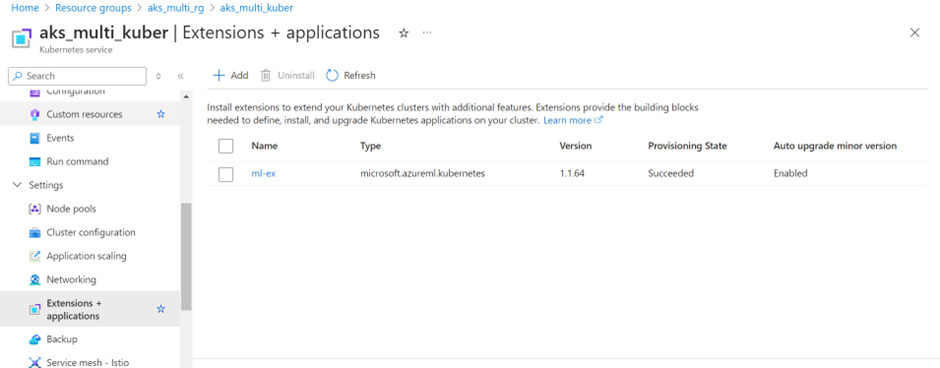

## Step 4: Attaching Your AKS Cluster to Azure Machine Learning Workspace

In this section, we will guide you through the process of attaching your Azure Kubernetes Service (AKS) cluster to Azure Machine Learning (Azure ML). This step is crucial for enabling the deployment of scalable machine learning models for training and inference workloads on Kubernetes clusters.

#### Prerequisites

Before proceeding, ensure you have:

1. **Azure ML Workspace**: A pre-configured Azure ML workspace.
2. **AKS Cluster**: An existing AKS cluster (or Azure Arc-enabled Kubernetes) with proper access permissions.
3. **Azure CLI and Azure ML SDK v2**: Installed and configured in your development environment.

#### Attaching AKS to Azure ML Workspace

You will need to provide the following values for the configuration:

- **`<your-compute-name>`**: A unique name for your Kubernetes compute resource in Azure ML.
- **`<SUBSCRIPTION_ID>`**: Your Azure subscription ID.
- **`<RESOURCE_GROUP>`**: The resource group where your AKS cluster resides.
- **`<CLUSTER_NAME>`**: The name of your AKS cluster.


-You can see attached cluster in compute section after it successfully run.
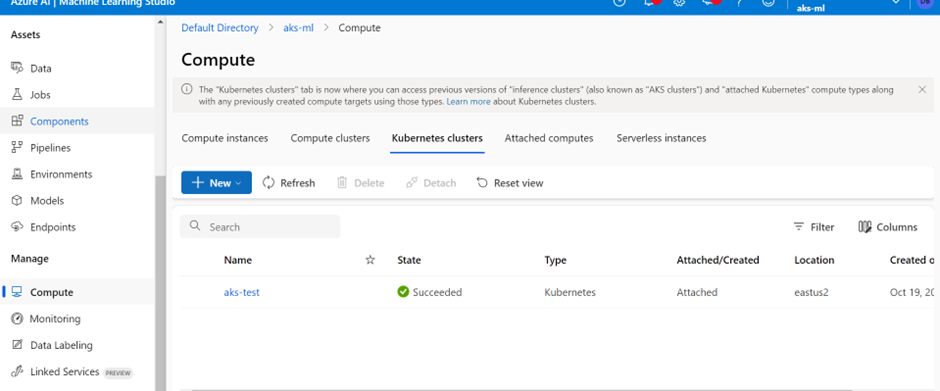

In [ ]:
from azure.ai.ml import load_compute

compute_name = "aks-test"

# for arc connected cluster, the resource_id should be something like '/subscriptions/<SUBSCRIPTION_ID>/resourceGroups/<RESOURCE_GROUP>/providers/Microsoft.ContainerService/connectedClusters/<CLUSTER_NAME>''
compute_params = [
    {"name": compute_name},
    {"type": "kubernetes"},
    {
        "resource_id": "/subscriptions/aa53648d-fdc9-4a6c-abaa-2cef054891ee/resourceGroups/aks-rg/providers/Microsoft.ContainerService/managedClusters/aks-cluster"
    },
]
k8s_compute = load_compute(source=None, params_override=compute_params)

compute_list = {c.name: c.type for c in ml_client.compute.list()}

if compute_name not in compute_list or compute_list[compute_name] != "kubernetes":
    ml_client.begin_create_or_update(k8s_compute).result()
else:
    print("Compute already exists")

## Step 5:Creating an Online Endpoint in Azure ML on Kubernetes

In this section, we will walk through creating a Kubernetes-based online endpoint in Azure Machine Learning (AML). An **online endpoint** allows you to deploy machine learning models for real-time inferencing.

### Code Explanation

The code below generates a unique name for the online endpoint based on the current date and time, and then creates a new Kubernetes-based online endpoint in AML.


In [100]:
online_endpoint_name = "k8s-endpoint-" + datetime.datetime.now().strftime("%m%d%H%M%f")

# create an online endpoint
endpoint = KubernetesOnlineEndpoint(
    name=online_endpoint_name,
    compute="aks-test",
    description="this is a sample online endpoint",
    auth_mode="key",
    tags={"foo": "bar"},
)

### Deploying the Online Endpoint in Azure Machine Learning

Once you've defined your Kubernetes-based online endpoint, the next step is to deploy it in Azure Machine Learning. In this section, we will use the `begin_create_or_update` method to create or update the endpoint.


### Code Explanation

The following code submits a request to Azure Machine Learning to either create or update the online endpoint we defined earlier:


In [ ]:
ml_client.online_endpoints.begin_create_or_update(endpoint).result()
"""
Initiates the creation or update of an online endpoint and waits for the operation to complete.

This function calls the `begin_create_or_update` method on the `ml_client.online_endpoints` object,
passing the `endpoint` as an argument. It then waits for the operation to complete by calling the
`result` method.

Args:
    endpoint: The endpoint configuration to be created or updated.

Returns:
    The result of the create or update operation.
"""

Endpoint deployed successfully!
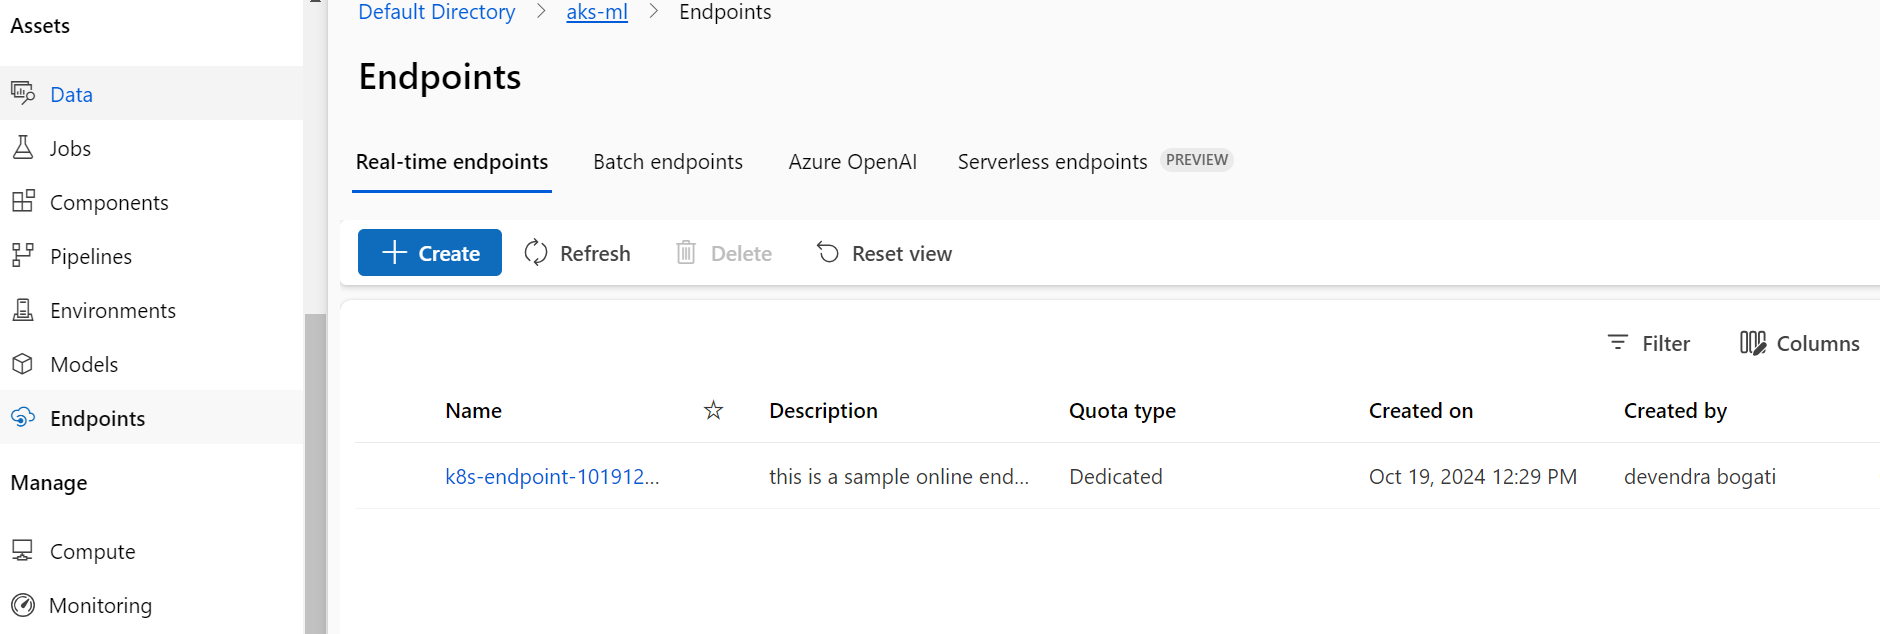
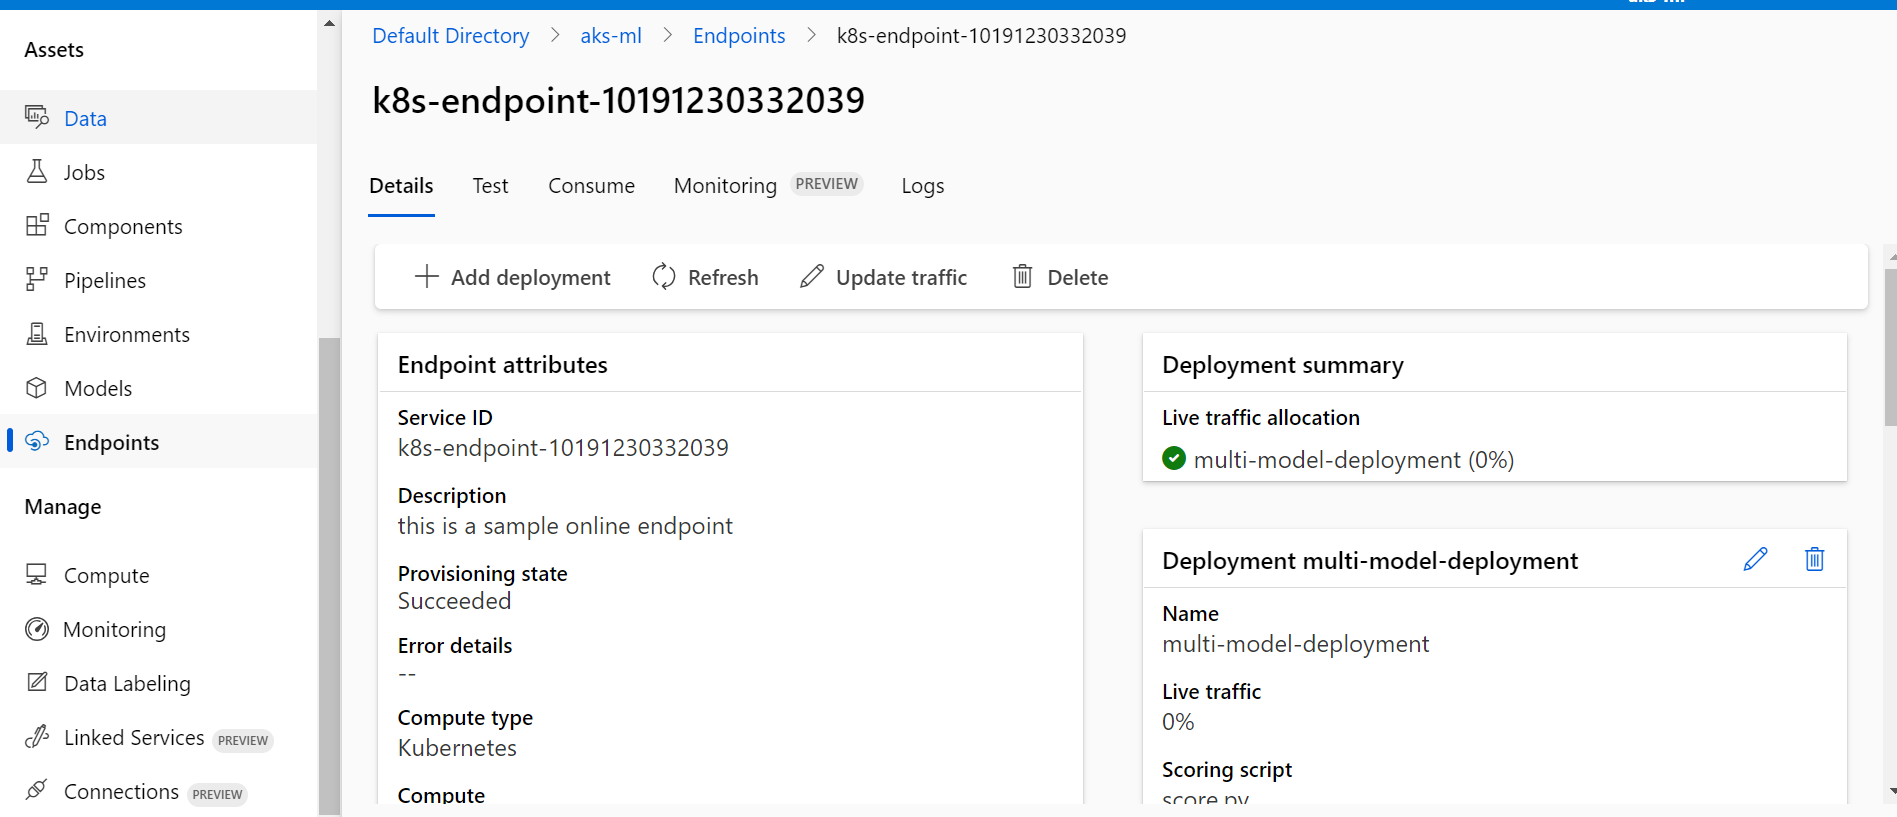

## Step 6: Setting Up Azure ML Environment for Kubernetes Endpoint Deployment

In this section, we'll create an Azure ML environment that defines all the dependencies your model needs to run efficiently on Kubernetes. This includes a Conda environment file and a Docker image.

### 1. Create Your Conda Environment File

You need to create a Conda YAML file that lists all the Python libraries and dependencies your model requires. Here's an example of a simple Conda file:

```yaml
channels:
  - conda-forge
dependencies:
  - python=3.10.12
  - pip<=22.3.1
  - pip:
      - mlflow
      - numpy
      - scikit-learn
      - pandas
      - azureml-inference-server-http
name: multi-model-env


In [126]:
env = Environment(
  
    conda_file=conda_file_path,# Specify the path to your Conda YAML file
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04",
)


In [ ]:
ml_client.environments.create_or_update(env)
"""
Creates or updates an Azure Machine Learning environment.

This function uses the `create_or_update` method from the `ml_client.environments` 
to either create a new environment or update an existing one with the provided 
environment configuration.

Args:
    env: The environment configuration object that specifies the details of 
         the environment to be created or updated.

Returns:
    The created or updated environment object.
"""

## Step 7:Deploying Multiple Models to a Kubernetes Endpoint

In this section, we will deploy multiple models to a Kubernetes endpoint using the `KubernetesOnlineDeployment` class. This deployment defines how your models will be served, including the environment setup, resource allocation, and the scoring logic.

####  Define the Kubernetes Deployment


In [136]:
# Define the Kubernetes deployment configuration for the multi-model deployment
aks_deployment = KubernetesOnlineDeployment(
    name="multi-model-deployment",  # Name of the deployment
    endpoint_name=online_endpoint_name,  # Name of the endpoint to deploy to
    model=Model(name="multimodel", path=models_path),  # Model configuration with name and path
    environment=env,  # Environment configuration
    code_configuration=CodeConfiguration(
        code=code_path, scoring_script="score.py"  # Path to the scoring script
    ),
    instance_count=1,  # Number of instances to deploy
    resources=ResourceRequirementsSettings(
        requests=ResourceSettings(
            cpu="100m",  # CPU resource request
            memory="0.5Gi",  # Memory resource request
        ),
    ),
)

### score.py Script for Azure ML Multi-Model Deployment

```python
import joblib
import json
import os
import pandas as pd
import logging
from pathlib import Path

# Declare models dictionary to hold the loaded models
models = None

# Initialize the models
def init():
    """
    This function is called when the container is initialized/started, typically after create/update of the deployment.
    You can write the logic here to perform init operations like caching the models in memory.
    """
    global models

    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    model_dir = Path(os.getenv("AZUREML_MODEL_DIR")) / "models"
    logging.info(f"Model directory: {model_dir}")

    try:
        # Load both churn and segmentation models
        models = {
            "churn_model": joblib.load(model_dir / "churn.joblib"),         # For supervised classification
            "segmentation_model": joblib.load(model_dir / "segmentation.joblib")  # For unsupervised clustering
        }
        logging.info(f"Loaded models: {list(models.keys())}")
    except FileNotFoundError as e:
        logging.error(f"Model file not found: {e}")
    except Exception as e:
        logging.error(f"Error during model loading in init: {e}")

# Run function to perform predictions
def run(raw_data):
    global models

    try:
        # Parse input data
        input_json = json.loads(raw_data)

        # Determine which model to run based on 'model_type' in input
        model_type = input_json.get("model_type", None)
        data = input_json.get("data", None)

        if model_type not in ["churn", "segmentation"]:
            raise ValueError("Invalid model_type. Choose either 'churn' or 'segmentation'.")

        if data is None:
            raise ValueError("Input data is missing.")

        input_data = pd.DataFrame(data)

        # Supervised classification: churn prediction
        if model_type == "churn":
            churn_model = models.get("churn_model")
            if churn_model is None:
                raise ValueError("Churn model not found.")
            
            # Perform churn prediction
            churn_predictions = churn_model.predict(input_data)
            result = {
                "churn_predictions": churn_predictions.tolist()
            }

        # Unsupervised clustering: segmentation
        elif model_type == "segmentation":
            segmentation_model = models.get("segmentation_model")
            if segmentation_model is None:
                raise ValueError("Segmentation model not found.")
            
            # Perform segmentation prediction
            segmentation_predictions = segmentation_model.predict(input_data)
            result = {
                "segmentation_predictions": segmentation_predictions.tolist()
            }

        return json.dumps(result)

    except Exception as e:
        error_message = str(e)
        logging.error(f"Error during prediction: {error_message}")
        return json.dumps({"error": error_message})
This script handles model inference for multiple models within an Azure Machine Learning (Azure ML) environment. It is designed to load models during the container's initialization and perform predictions based on input requests. Below is a breakdown of the key components and flow:

1. Model Initialization (init function)
Purpose: The init function is called when the container is first initialized (e.g., after deployment or update). Its main role is to load the pre-trained models and cache them in memory for quick access.

Environment Variable: It uses the AZUREML_MODEL_DIR environment variable to locate where the models are stored inside the deployed container. This directory is automatically set by Azure ML during the deployment process.

Models Loaded:

churn_model: For supervised classification tasks (e.g., predicting churn).
segmentation_model: For unsupervised clustering tasks (e.g., customer segmentation).
Error Handling: The function includes error handling in case models cannot be found or loaded, logging errors for easier debugging.

2. Prediction (run function)
Purpose: The run function is triggered when a request is made to the deployed model endpoint. It parses the incoming request (in JSON format) and routes the input data to the correct model based on the model_type specified.

Input: The function expects a JSON object containing two keys:

model_type: Specifies whether to use the churn model (supervised) or segmentation model (unsupervised).
data: Contains the input data that will be used for predictions. This data is converted into a pandas.DataFrame for compatibility with the model.
Model Selection:

Churn Prediction: If model_type == "churn", the churn_model is used to perform predictions.
Segmentation: If model_type == "segmentation", the segmentation_model is used to cluster the data.
Error Handling:

If the model_type is not recognized or if data is missing, it raises a ValueError and returns an error message.
Logs errors during prediction for troubleshooting.

Use the following code to start the deployment process:


In [ ]:
ml_client.begin_create_or_update(aks_deployment).result()


Model deployed Successfully!
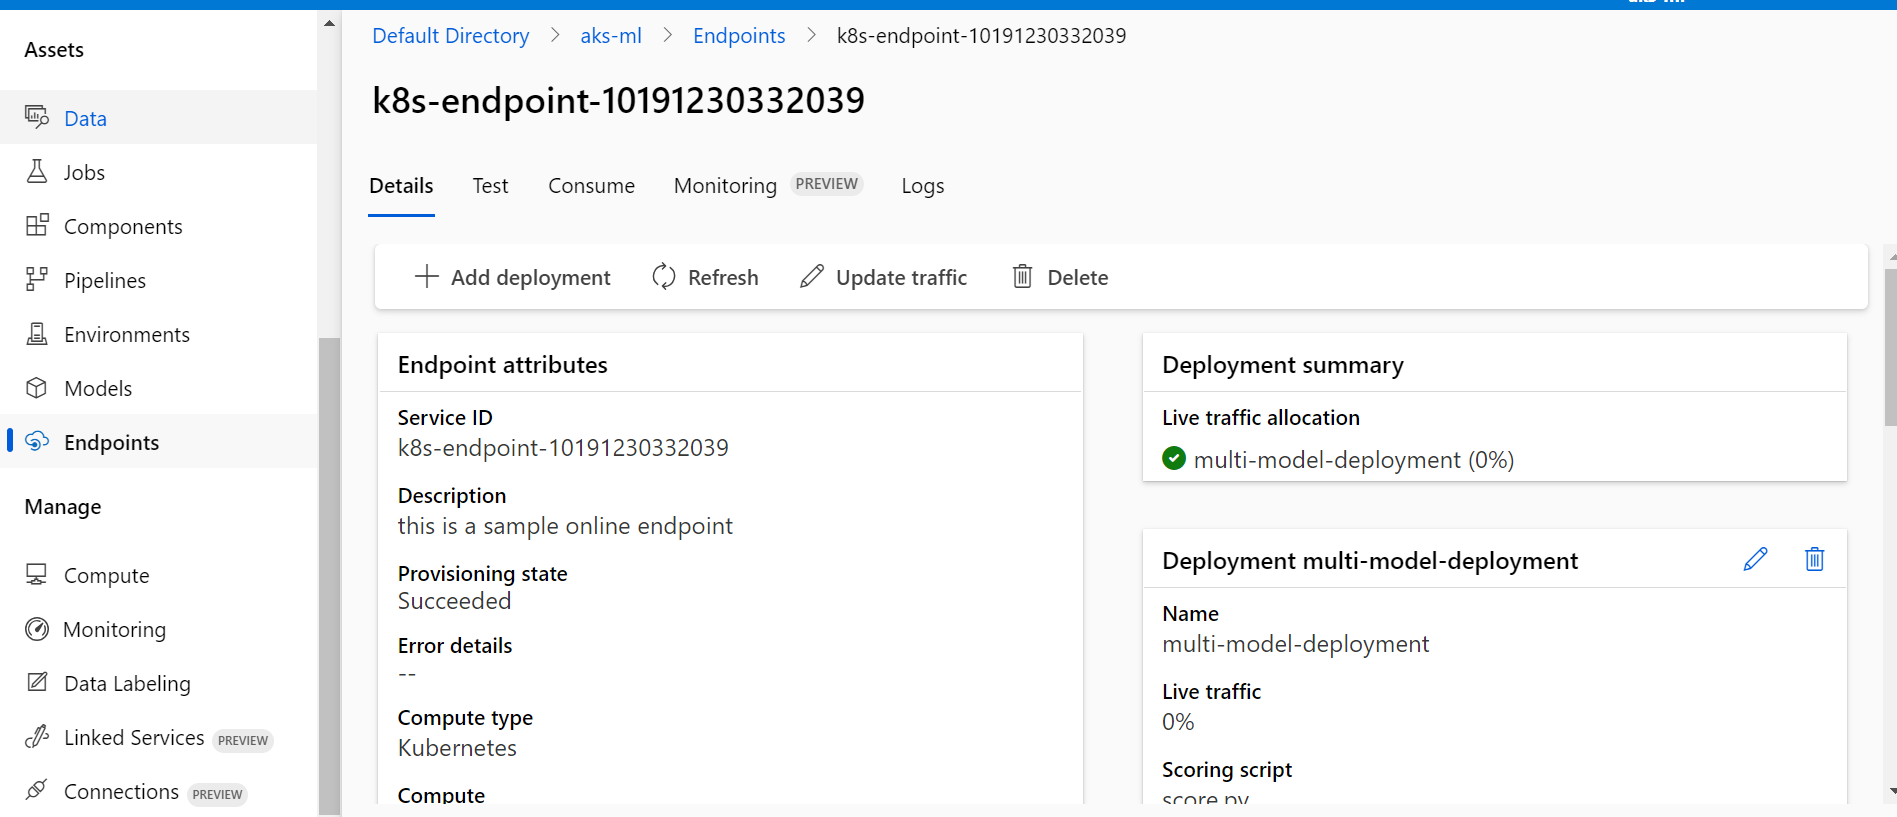

use this code to check any error during deployment.

In [ ]:
from azure.ai.ml.operations import OnlineDeploymentOperations

# Fetch deployment logs to check for errors
logs = ml_client.online_deployments.get_logs(
    name="multi-model-deployment",
    endpoint_name=online_endpoint_name,
    lines=300  # Specify how many lines of logs you want
)
print(logs)


Sets the traffic allocation for the deployment named "multi-model-deployment" to 100%.

In [ ]:


endpoint.traffic = {"multi-model-deployment": 100}
ml_client.begin_create_or_update(endpoint).result()

## Step 8:Prediction using endpoint

Copy endpoint and key for prediction
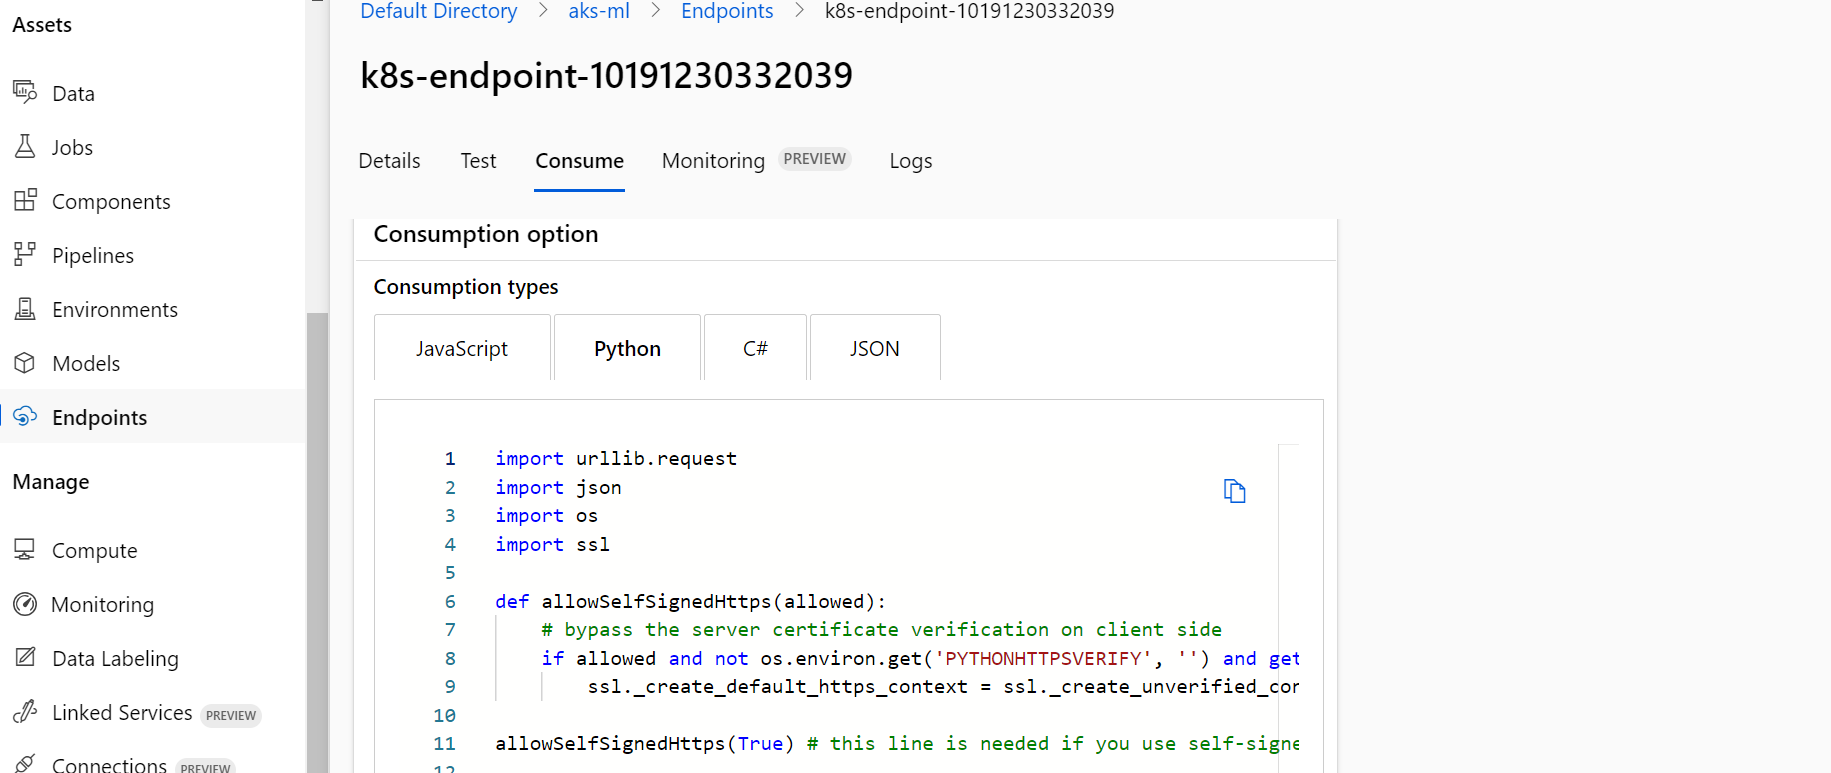

Churn Prediction

In [ ]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Define the request data, this is for churn model testing
data = {
    "model_type": "churn",
    "data": [
        {
            "age": 24.0,
            "monthly_usage": 60000.789871,
            "account_duration": 45.0,
            "payment_history": 1.0,
            "customer_support_calls": 8.0,
            "product_tier": 7.0
        },
        {
            "age": 69.0,
            "monthly_usage": 64.049905,
            "account_duration": 18.0,
            "payment_history": 1.0,
            "customer_support_calls": 1.0,
            "product_tier": 3.0
        }
    ]
}

body = str.encode(json.dumps(data))

# Your endpoint URL
url = 'your-endpoint-url'
# Replace this with the primary/secondary key for the endpoint
api_key = 'your-api-key'

headers = {'Content-Type': 'application/json', 'Authorization': ('Bearer ' + api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)
    result = response.read()
    print(result.decode("utf-8"))
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))


Segmentation Prediction


In [ ]:
import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Define the request data, this is for churn model testing
data = {
    "model_type": "segmentation",
    "data": [
        {
            "age": 47,
            "monthly_usage": 58.71003942,
            "account_duration": 47,
            "payment_history": 1,
            "customer_support_calls": 5,
            "product_tier": 3
        },
        {
            "age": 57,
            "monthly_usage": 32.55805896,
            "account_duration": 60,
            "payment_history": 0,
            "customer_support_calls": 5,
            "product_tier": 1
        },
        {
            "age": 23,
            "monthly_usage": 72.86899661,
            "account_duration": 15,
            "payment_history": 0,
            "customer_support_calls": 6,
            "product_tier": 1
        },
        {
            "age": 37,
            "monthly_usage": 54.69110503,
            "account_duration": 5,
            "payment_history": 0,
            "customer_support_calls": 8,
            "product_tier": 2
        },
        {
            "age": 37,
            "monthly_usage": 47.89492434,
            "account_duration": 69,
            "payment_history": 1,
            "customer_support_calls": 2,
            "product_tier": 1
        }
    ]
}
body = str.encode(json.dumps(data))

# Your endpoint URL
url = 'http://48.211.140.76/api/v1/endpoint/k8s-endpoint-10191230332039/score'
# Replace this with the primary/secondary key for the endpoint
api_key = 'tdi4xbCdtY4tgQU2y99xmi5wPIS83hRz'

headers = {'Content-Type': 'application/json', 'Authorization': ('Bearer ' + api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)
    result = response.read()
    print(result.decode("utf-8"))
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))

## Step 9:Delete deployment and endpoint

First downsize traffic to zero.

In [ ]:
endpoint.traffic = {"multi-model-deployment": 0}
"""
This code snippet sets the traffic allocation for the specified endpoint to zero and then updates the endpoint configuration.

Attributes:
    endpoint (Endpoint): The endpoint object to be updated.
    ml_client (MLClient): The machine learning client used to interact with the Azure ML service.

Operations:
    - Sets the traffic allocation for the "multi-model-deployment" to 0.
    - Initiates the update process for the endpoint configuration using the `begin_create_or_update` method.
    - Waits for the update operation to complete by calling the `result` method.
"""
ml_client.begin_create_or_update(endpoint).result()

delete deployment.

In [ ]:
ml_client.online_deployments.begin_delete(
    """
    Deletes the "blue" deployment from the specified online endpoint.

    This function initiates the deletion of the deployment named "blue" from the 
    online endpoint specified by `online_endpoint_name`. The deletion process 
    is asynchronous, and the function waits for the operation to complete before 
    returning.

    Args:
        name (str): The name of the deployment to delete. In this case, it is "blue".
        endpoint_name (str): The name of the online endpoint from which the deployment 
                             will be deleted.

    Returns:
        None: This function does not return any value. It waits for the deletion 
              operation to complete before returning.
    """
    name="blue", endpoint_name=online_endpoint_name
).result()

delete endpoint

In [ ]:
ml_client.online_endpoints.begin_delete(name=online_endpoint_name)
"""
Deletes an existing online endpoint.

This function initiates the deletion of an online endpoint specified by the 
`online_endpoint_name` parameter. The deletion process is asynchronous.

Parameters:
    name (str): The name of the online endpoint to be deleted.

Returns:
    None
"""